In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import io
import time
import random

import matplotlib.pyplot as plt
import seaborn 

## Step 1. 데이터 다운로드

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

## Step 2. 데이터 정제 및 토큰화

**데이터 중복 제거**

In [3]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    df = pd.DataFrame({
        'ko' : kor,
        'en' : eng
    })
    
    df.drop_duplicates(['ko'], inplace=True, ignore_index=True)
    df.drop_duplicates(['en'], inplace=True, ignore_index=True)

    return df

cleaned_corpus = clean_corpus(kor_path, eng_path)

* 모든 입력을 소문자로 변환합니다.
* 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
* 문장부호 양옆에 공백을 추가합니다.
* 문장 앞뒤의 불필요한 공백을 제거합니다.

In [4]:
import re

def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()  # 소문자화
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)  # 기타 문자 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 기호처리
    sentence = re.sub(r'[" "]+', " ", sentence)  # 연속 공백 처리
    sentence = sentence.strip()  # 양쪽 공백 제거
    
    return sentence

In [5]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):

    temp_data_dir = os.getenv('HOME')+'/aiffel/transformer/temp'
    temp_file = f'{temp_data_dir}/temp_{lang}_corpus.txt'
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row)+"\n")
    
    prefix = f"{lang}_tokenizer"
    
    # Train the SentencePiece model
    spm.SentencePieceTrainer.train(
        input=temp_file,
        model_prefix=prefix,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id
    )
    
    # Load the trained model
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{prefix}.model")
    
    # Remove the temporary file
    os.remove(temp_file)
    
    return tokenizer

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in zip(cleaned_corpus['ko'], cleaned_corpus['en']):
    k, e = pair

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/temp/temp_ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 

True

In [6]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해
import tensorflow as tf

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    k_tokens = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    e_tokens = en_tokenizer.encode_as_ids(eng_corpus[idx])
    
    if len(k_tokens) <= 50 and len(e_tokens) <= 50:
        src_corpus.append(k_tokens)
        tgt_corpus.append(e_tokens)    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/74849 [00:00<?, ?it/s]

In [7]:
# 결과 확인
print(f"src_corpus의 길이: {len(src_corpus)}")
print(f"tgt_corpus의 길이: {len(tgt_corpus)}")
print(f"enc_train의 shape: {enc_train.shape}")
print(f"dec_train의 shape: {dec_train.shape}")

src_corpus의 길이: 68196
tgt_corpus의 길이: 68196
enc_train의 shape: (68196, 50)
dec_train의 shape: (68196, 50)


## Step 3. 모델 설계

* Transformer 모델 설계

In [8]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        """
        Scaled QK 값 구하기
        """
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [10]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [12]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [15]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [16]:
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = 20000
target_vocab_size = 20000
pos_len = 20000
dropout_rate = 0.2

# Transformer 모델 선언
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pos_len, dropout=dropout_rate)

In [17]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

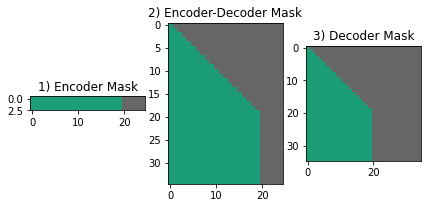

In [18]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [19]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [21]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [22]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [23]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [24]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [25]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 100

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_1148/1026624860.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the  ⁇ 
Input: 시민들은 도시 속에 산다.
Predicted translation: the united states of the world
Input: 커피는 필요 없다.
Predicted translation: the  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the united states , the first .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a new york .
Input: 시민들은 도시 속에 산다.
Predicted translation: the government is the most of the world .
Input: 커피는 필요 없다.
Predicted translation: it is a lot of the way .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the people were killed in the city of the city .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a year old president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the two people are in the city of the river .
Input: 커피는 필요 없다.
Predicted translation: it is a very very .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president elected .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a lot of city .
Input: 커피는 필요 없다.
Predicted translation: it s  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the second half of the death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president electing president elect obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in the city of
Input: 커피는 필요 없다.
Predicted translation: coffee is not a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the death .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of kandahar city .
Input: 커피는 필요 없다.
Predicted translation: don t know , or cheap .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of kandahar .
Input: 커피는 필요 없다.
Predicted translation: coffee don t be  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city police have hit city city .
Input: 커피는 필요 없다.
Predicted translation: coffee or travelers are  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two of the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of city residents .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents are flower in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee don t demand .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city residents .
Input: 커피는 필요 없다.
Predicted translation: coffee don t be allowed to drink coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths were killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents of the city .
Input: 커피는 필요 없다.
Predicted translation: cup don t demand .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there was in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee don t drink  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in the death of death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city . .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is a neighborhood .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two of the death toll was killed in a .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there was a city neighborhood .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key country in north korea .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents . .
Input: 커피는 필요 없다.
Predicted translation: customers must pay customers demand .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the second day of death .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key country of president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city residents of the city s city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in the . five death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key part of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: there is around a city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . magnitude toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city residents .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed on a .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a part of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city residents .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city city city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in , according to another .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is around there .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . magnitude of death death killed at least .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key thing .
Input: 시민들은 도시 속에 산다.
Predicted translation: city towns city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on the death toll was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: city towns city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . magnitude of death killed at least .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key country of president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s . death toll on the death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyed blue .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people died in .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a part of north korea .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of wine .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people died wednesday .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key thing .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city of duwaid city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed in algeria .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a part of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit the city of christians .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s . death toll in the .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a part of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll on people were killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a close way .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyed it a neighborhood of a city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people died of .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets city grew to the city .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed in the august .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a place today .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city resident of city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed in algeria .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: city resident of city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight died in the blast killed at least .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a place today .
Input: 시민들은 도시 속에 산다.
Predicted translation: city towns city put there on the city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death occurred in the second quarter .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a part of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets city of except .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s . death toll


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyed water .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people died in .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a place north korea .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of she kid on there .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . magnitude of the death killed at least .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of sand are purely on the city .
Input: 커피는 필요 없다.
Predicted translation: coffee farewell to register
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed in a bomb near the death .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is a national day .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of housing .
Input: 커피는 필요 없다.
Predicted translation: coffee traveling to fix or sign
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people died in the attack .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city towns city of we fast in the city of
Input: 커피는 필요 없다.
Predicted translation: coffee at coffee park
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people died in killing , one of people died in u . s .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a close obama north of north korea .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit city .
Input: 커피는 필요 없다.
Predicted translation: coffee any employers fix
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed in algeria .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a place today .
Input: 시민들은 도시 속에 산다.
Predicted translation: city towns city around in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll on death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very different way .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll on people were killed in algeria .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyedison in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death occurred on people .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyed water .
Input: 커피는 필요 없다.
Predicted translation: coffee any migrant at time
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll on death of people killed in u . s .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a close obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit city .
Input: 커피는 필요 없다.
Predicted translation: coffee any consumers check
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed in the attack .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: city s city s port for city .
Input: 커피는 필요 없다.
Predicted translation: export any travel
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . estimate .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important agenda .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of restaurants .
Input: 커피는 필요 없다.
Predicted translation: coffee applys for alternative
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll on death .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: city was surrounded .
Input: 커피는 필요 없다.
Predicted translation: coffee traveling to demand  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people died in killed in the august .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit city s town .
Input: 커피는 필요 없다.
Predicted translation: coffee apply
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the . people were killed in a crowd .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high on today .
Input: 시민들은 도시 속에 산다.
Predicted translation: city s city of salt is .
Input: 커피는 필요 없다.
Predicted translation: coffee apply
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated people were killed in the attack .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets city of except .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high on today .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets city .
Input: 커피는 필요 없다.
Predicted translation: coffee at coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll on deaths .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: year old streets .
Input: 커피는 필요 없다.
Predicted translation: caffeine must stay for customers non caffeine driving
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates . .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyed water .
Input: 커피는 필요 없다.
Predicted translation: export any employers rejected or meals .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city was city .
Input: 커피는 필요 없다.
Predicted translation: coffee traveling to don t necessarily
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: more than people died in the attack .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of restaurants .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll on death .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a day .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit city .
Input: 커피는 필요 없다.
Predicted translation: coffee traveling to fix
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates were killed in algeria .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is in north america .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of housing .
Input: 커피는 필요 없다.
Predicted translation: export any migrant traveling
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . death killed at people .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state in north korea .
Input: 시민들은 도시 속에 산다.
Predicted translation: city was quiet .
Input: 커피는 필요 없다.
Predicted translation: coffee any consumers must be clean .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in afghanistan .
Input: 시민들은 도시 속에 산다.
Predicted translation: city towns city around in there .
Input: 커피는 필요 없다.
Predicted translation: coffee traveling to fix
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated people .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship with president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city was around city .
Input: 커피는 필요 없다.
Predicted translation: coffee traveling to coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated people dead .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets , located in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: another people were killed in aig on april .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a different day .
Input: 시민들은 도시 속에 산다.
Predicted translation: city towns city around in there .
Input: 커피는 필요 없다.
Predicted translation: coffee apply
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people died in the attacks of death .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates . .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the same country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyedison in there .
Input: 커피는 필요 없다.
Predicted translation: caffeine must stay for at coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship with president .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people died . eight people including one bomb death killed in iran .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a real way .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets , she torn city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two . people were killed in iran .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high life in north korea .
Input: 시민들은 도시 속에 산다.
Predicted translation: city towns city around in there are a kid town .
Input: 커피는 필요 없다.
Predicted translation: don t even find non requires at .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated people were killed in a small .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big enemies today .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , beautiful city
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates were killed on april .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high school in north korea .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , there s just only the city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the same day .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of housing it off .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates were killed on april .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the real country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city streets , located just city .
Input: 커피는 필요 없다.
Predicted translation: don t even reason to demand fix traveling .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated dead .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the same day .
Input: 시민들은 도시 속에 산다.
Predicted translation: from , city oflight is the city .
Input: 커피는 필요 없다.
Predicted translation: caffeine must stay for at .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: another people were killed in algeria s august , according to one official died .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city oflights sheed in the city of .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city oflights she grew .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll wednesday was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the state .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city oflight is the city .
Input: 커피는 필요 없다.
Predicted translation: even at coffee e mail
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state of america .
Input: 시민들은 도시 속에 산다.
Predicted translation: from when we beautiful city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . death killed at people .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama a key country a state that is a close part of that president obama s in north wazirney .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , beach towns residents of the city .
Input: 커피는 필요 없다.
Predicted translation: even at the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimates of people died wednesday .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high life in north america .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city oflight is the city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three people were killed in algeria s state department .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in just different north of north america .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , restaurant janewais .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated deadly injured one death toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very important .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city oflight is the city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated deadly toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: city enjoyed water .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll wednesday was killed on april .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the state .
Input: 시민들은 도시 속에 산다.
Predicted translation: from , city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the state .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city of wine is .
Input: 커피는 필요 없다.
Predicted translation: caffeine must stay for at .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the real country .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of harper is off .
Input: 커피는 필요 없다.
Predicted translation: don t even find fix cent
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a close obama come to president .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city of height of city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated dead of people killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big relationship .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city towns live .
Input: 커피는 필요 없다.
Predicted translation: don t even lost .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: eight people died on the death .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the state .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of spa called .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll wednesday was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a close president of what is about today .
Input: 시민들은 도시 속에 산다.
Predicted translation: city hit city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll wednesday was killed , according wednesday .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the real country .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city oflight is the city .
Input: 커피는 필요 없다.
Predicted translation: caffeine must stay for at .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll wednesday was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the same day .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city was kid .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state in north america .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city of wine is just one of city .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . magnitude . s death toll wednesday was killed .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state of america .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , city of kandahar was again city .
Input: 커피는 필요 없다.
Predicted translation: caffeine must stay for d department .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a high in the state .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city enjoyed liv .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated deadly toll .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state in north america .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city streets of restaurants .
Input: 커피는 필요 없다.
Predicted translation: consumers the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated dead of people killed , .


  0%|          | 0/1066 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state .
Input: 시민들은 도시 속에 산다.
Predicted translation: from city , streets .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .


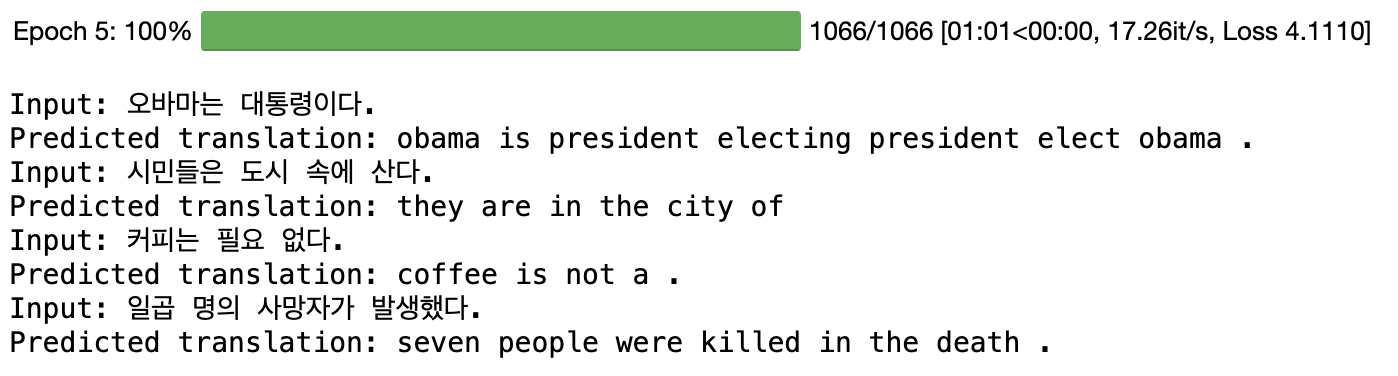

일곱명의 사망자가 발생했다.  
-> seven people were killed in the death .

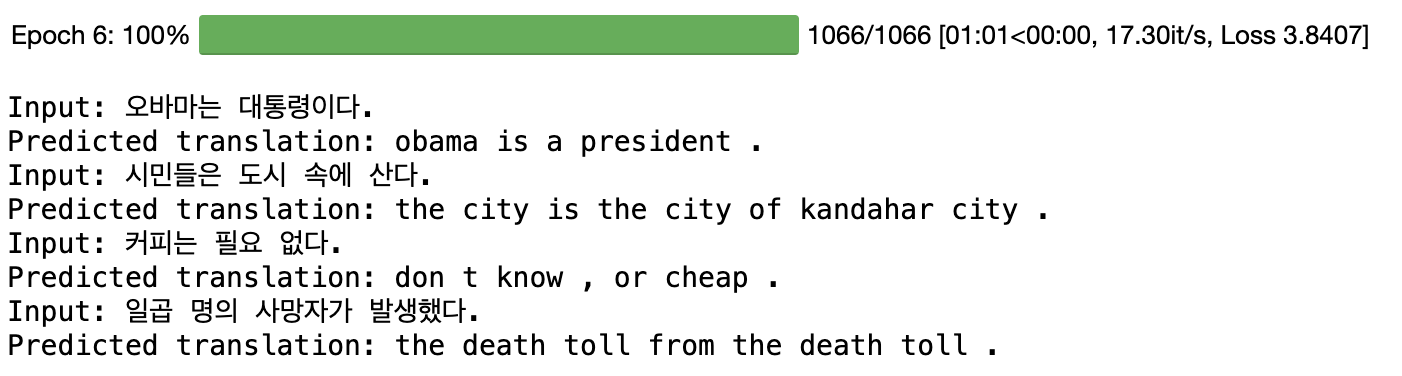

오바마는 대통령이다.  
-> obama is a president .

Input: 오바마는 대통령이다.
Predicted translation: obama is a big state .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


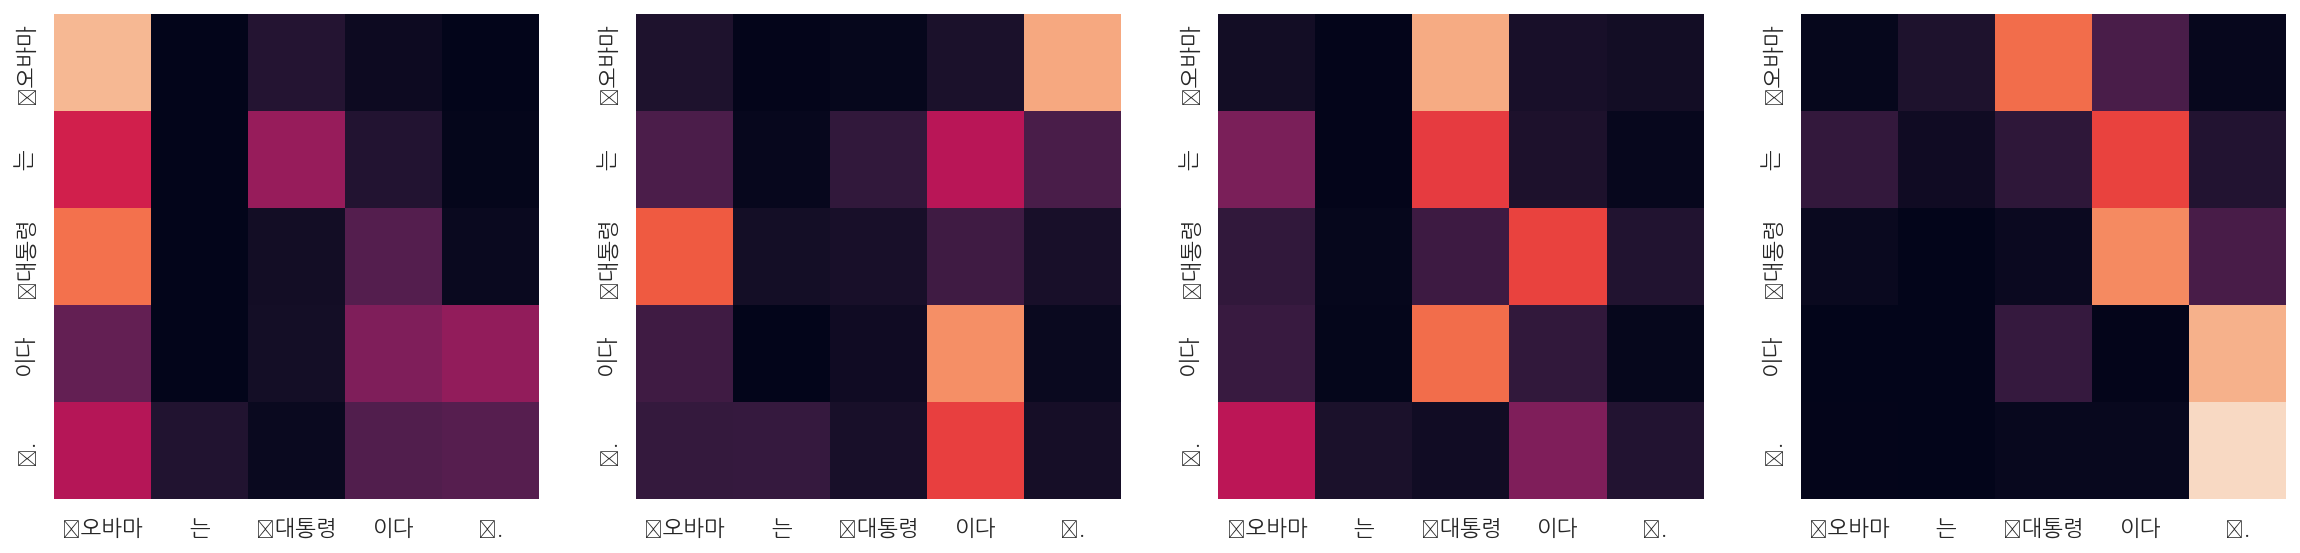

Encoder Layer 2


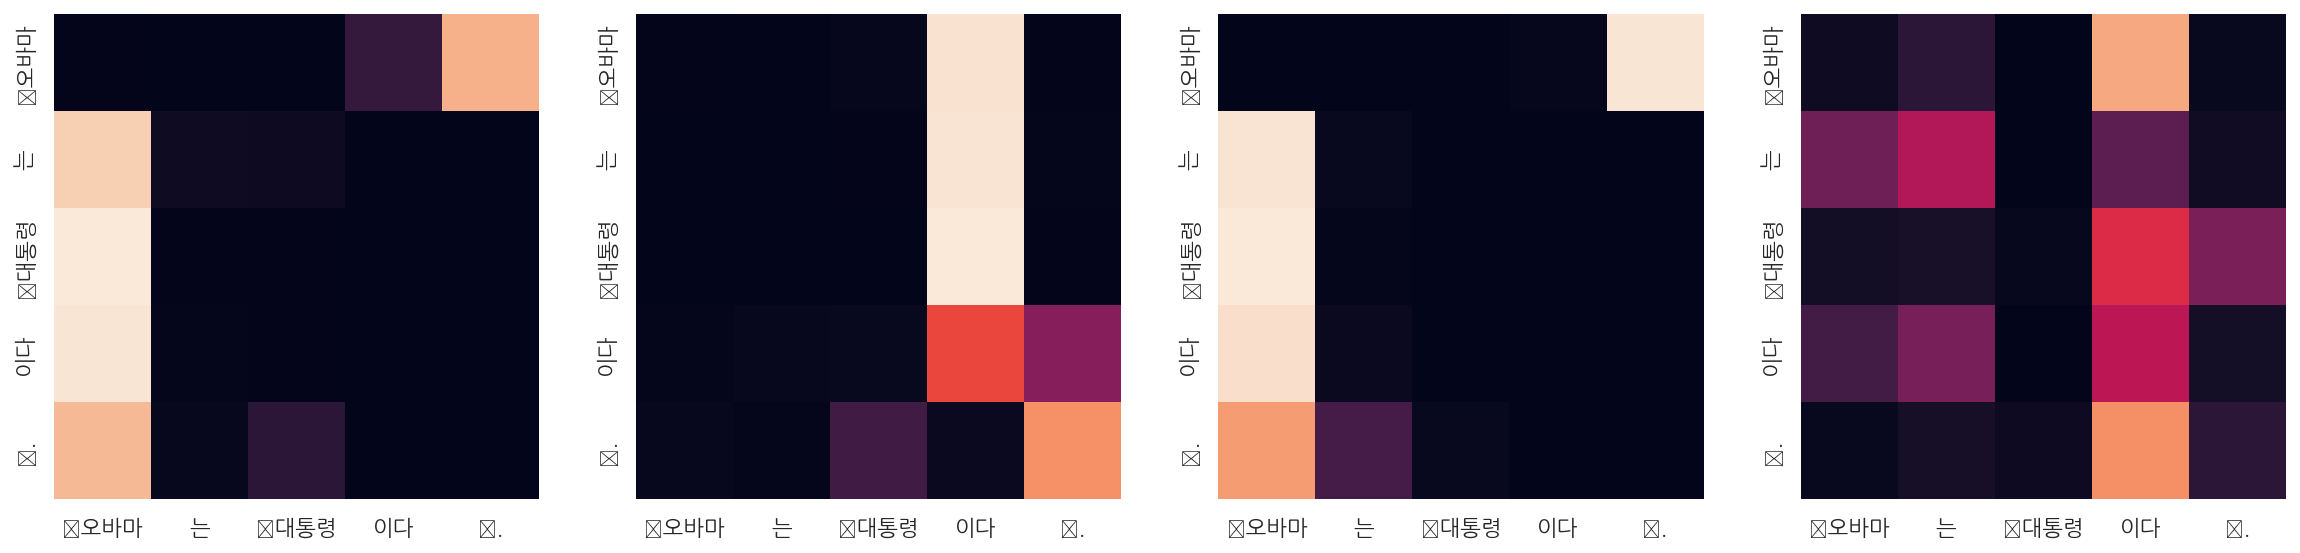

Decoder Self Layer 1


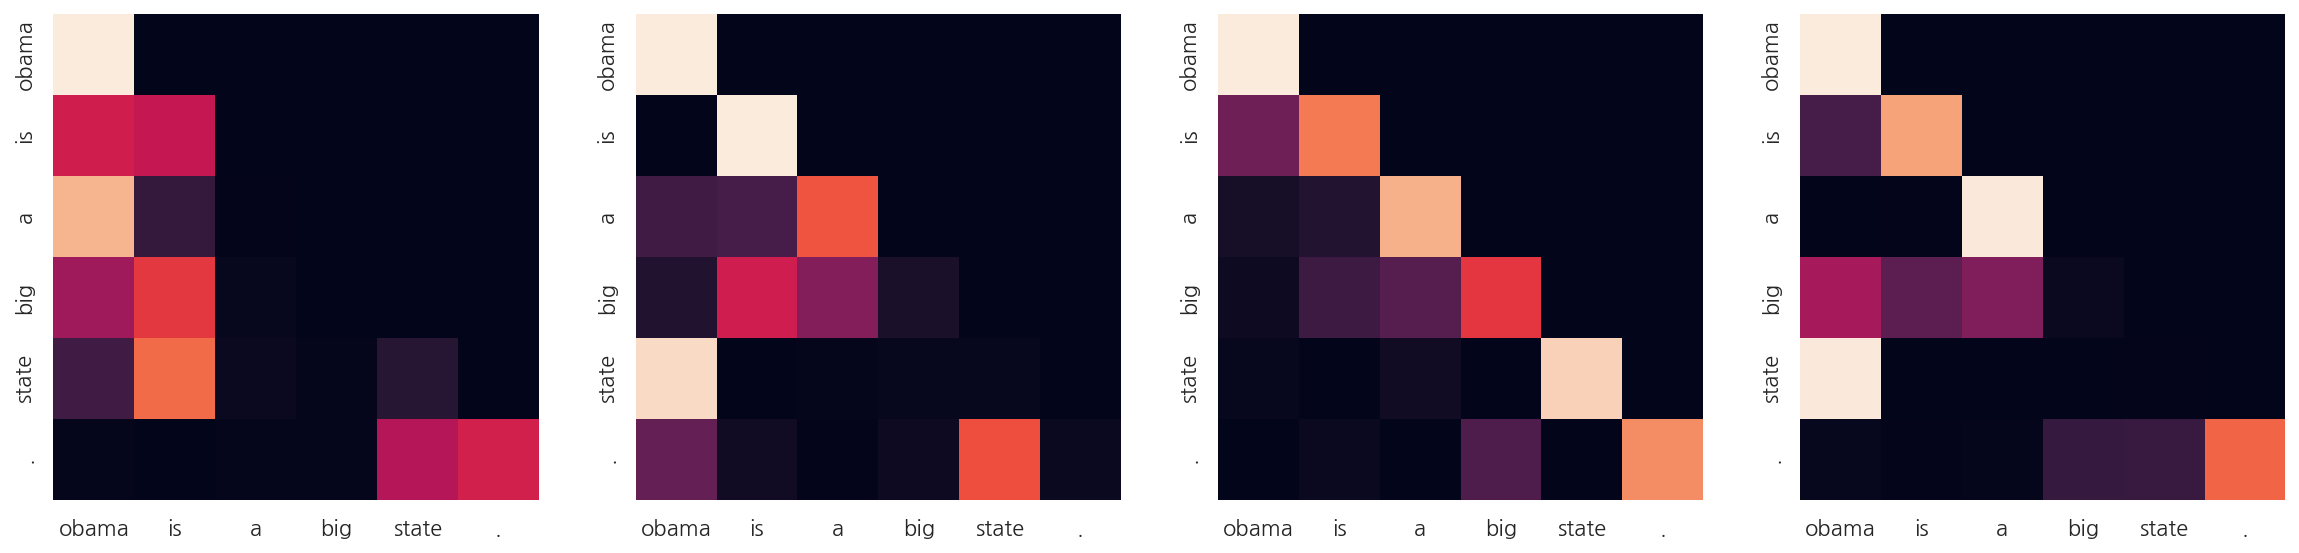

Decoder Src Layer 1


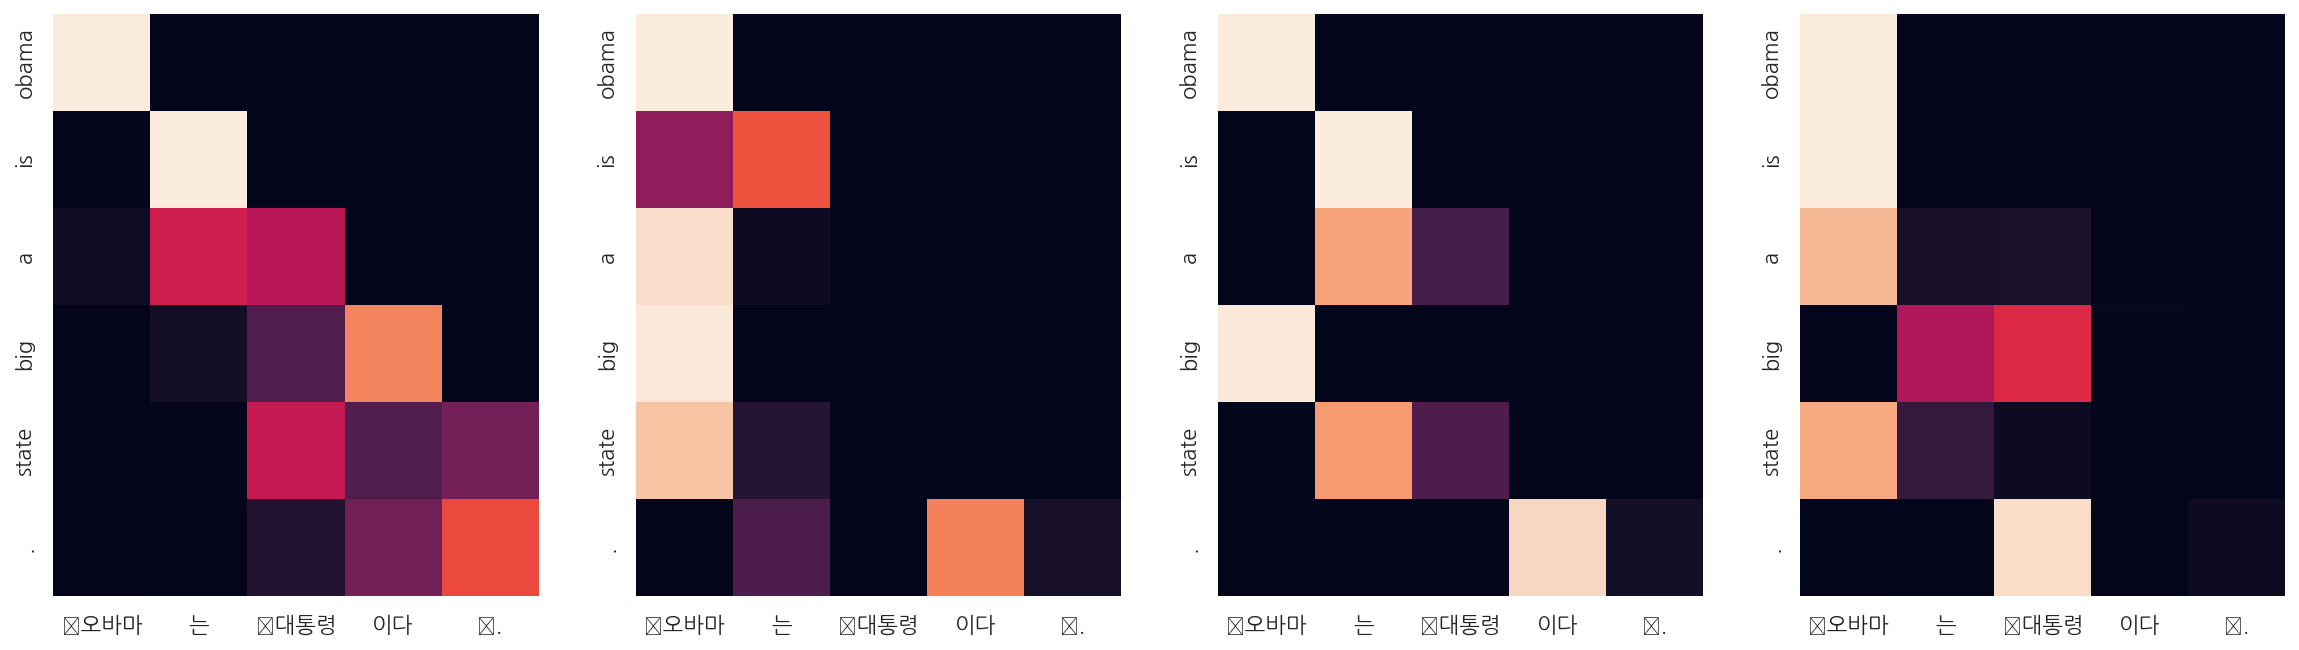

Decoder Self Layer 2


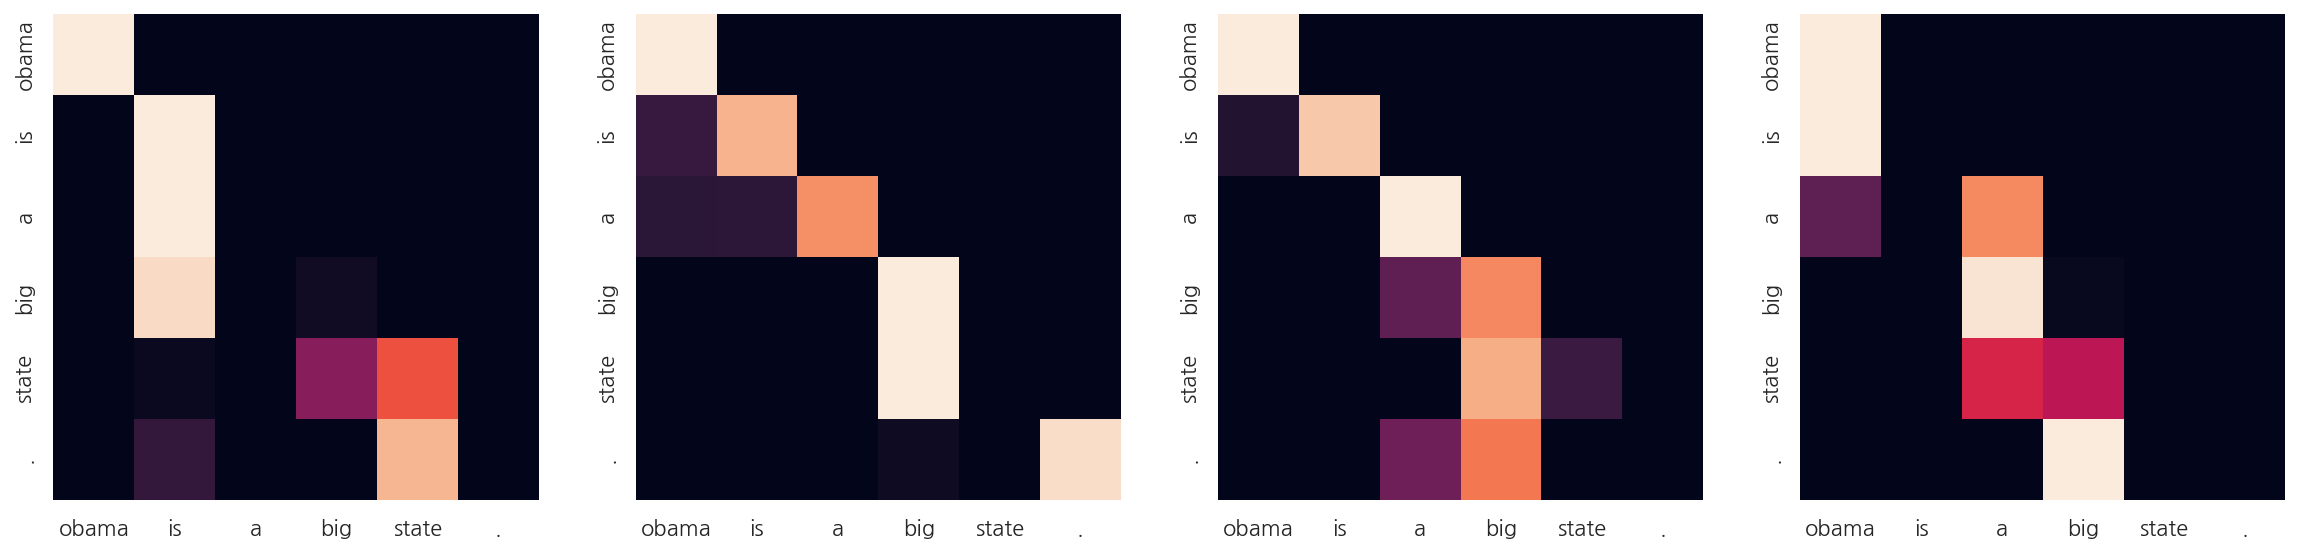

Decoder Src Layer 2


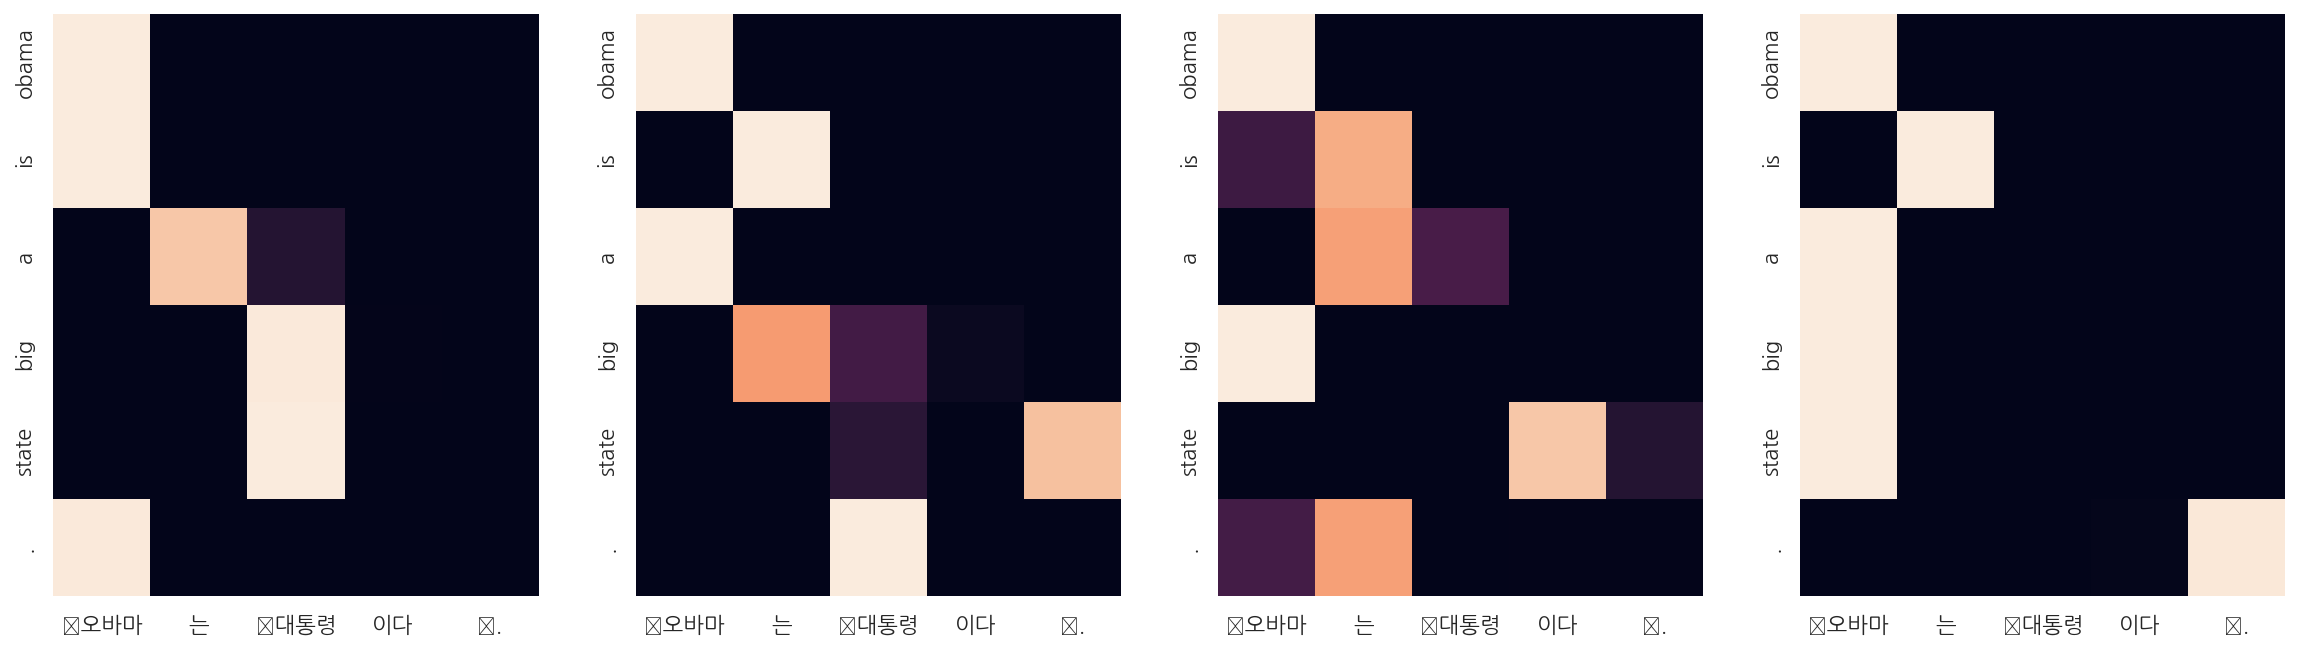

Input: 시민들은 도시 속에 산다.
Predicted translation: from city , streets .
Encoder Layer 1


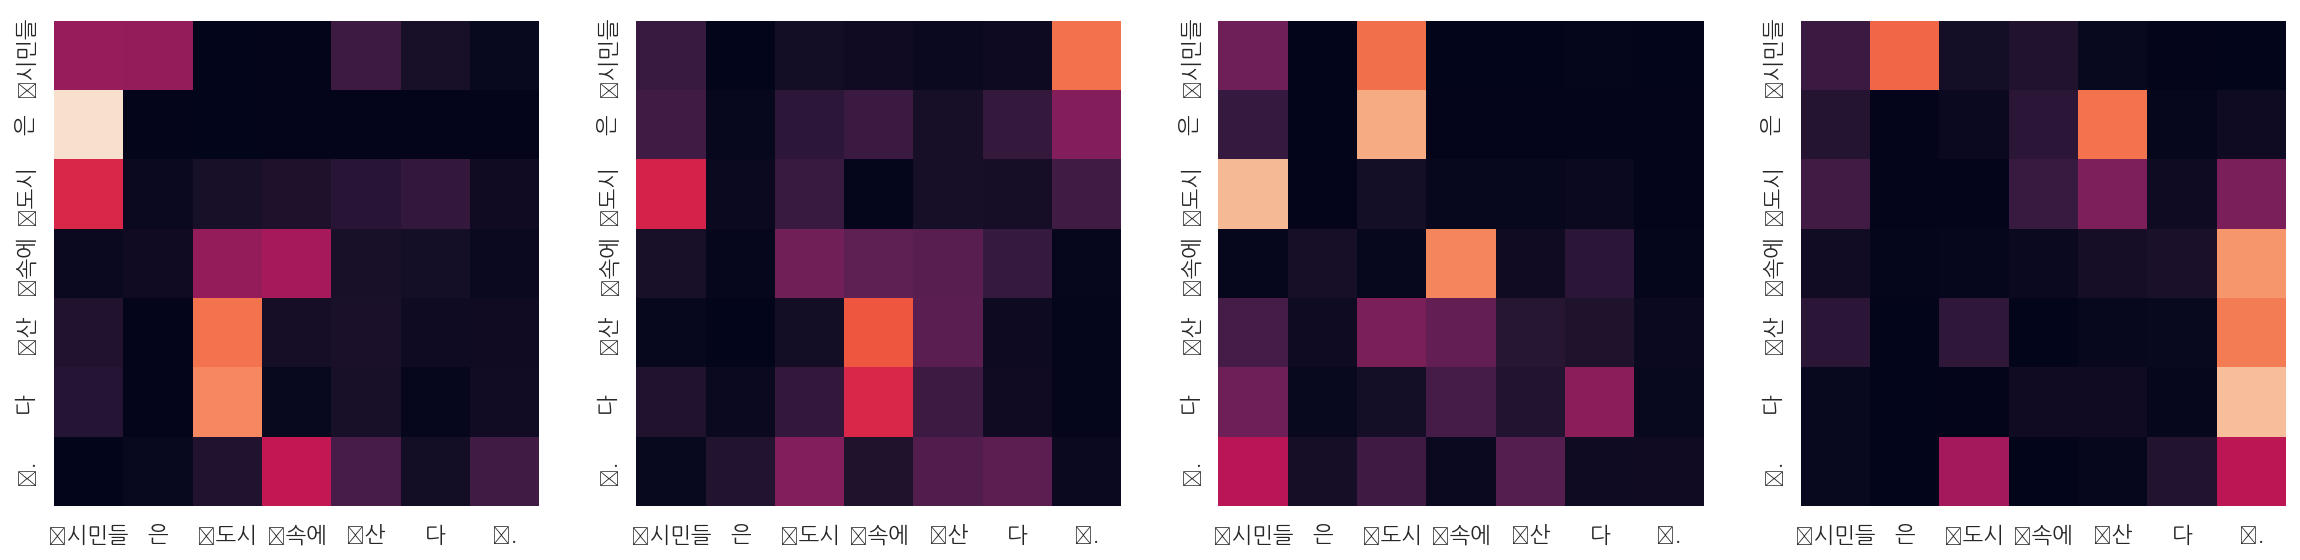

Encoder Layer 2


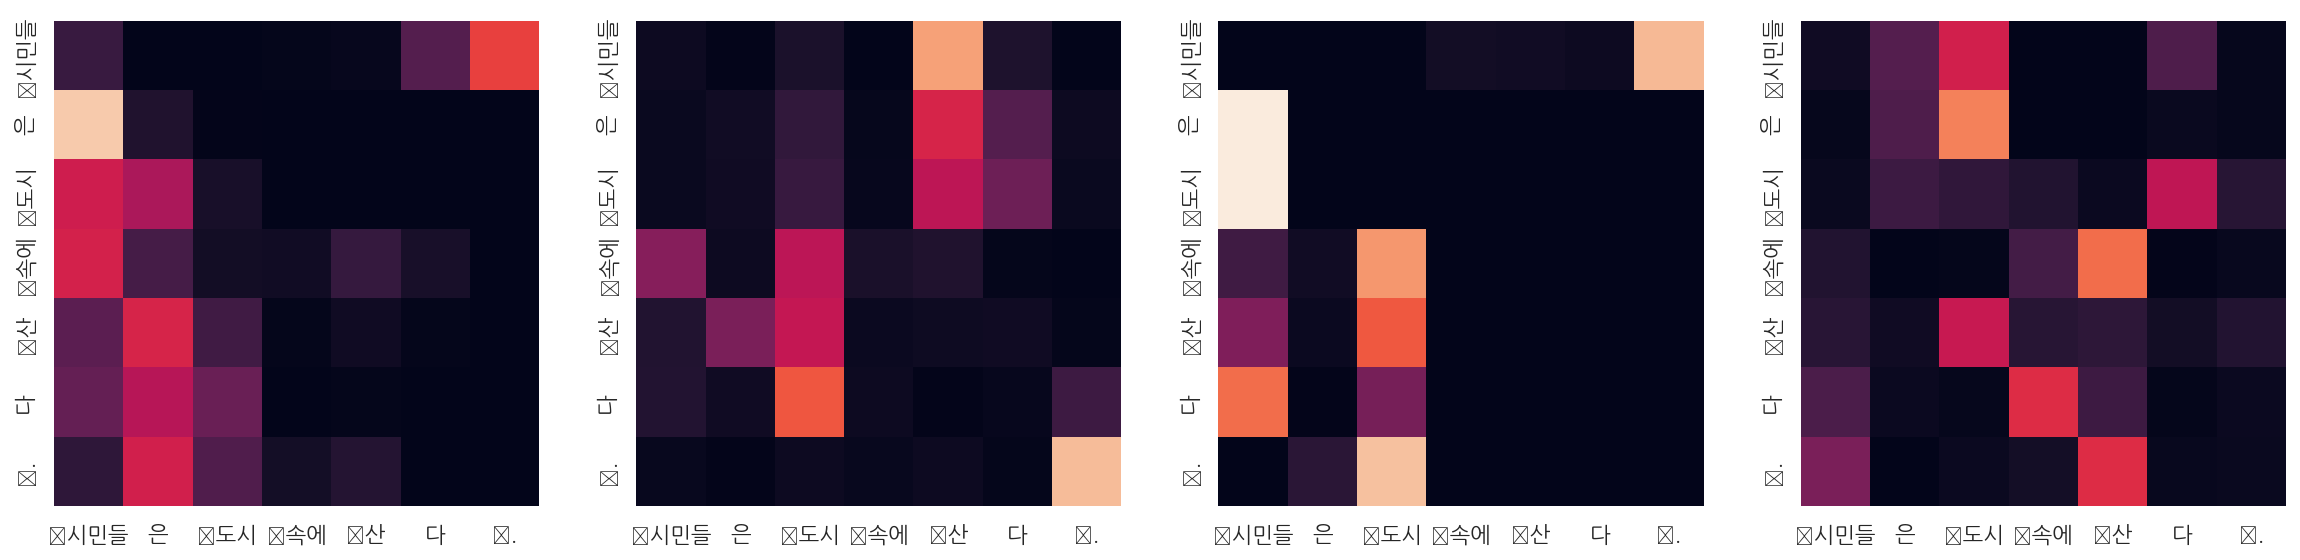

Decoder Self Layer 1


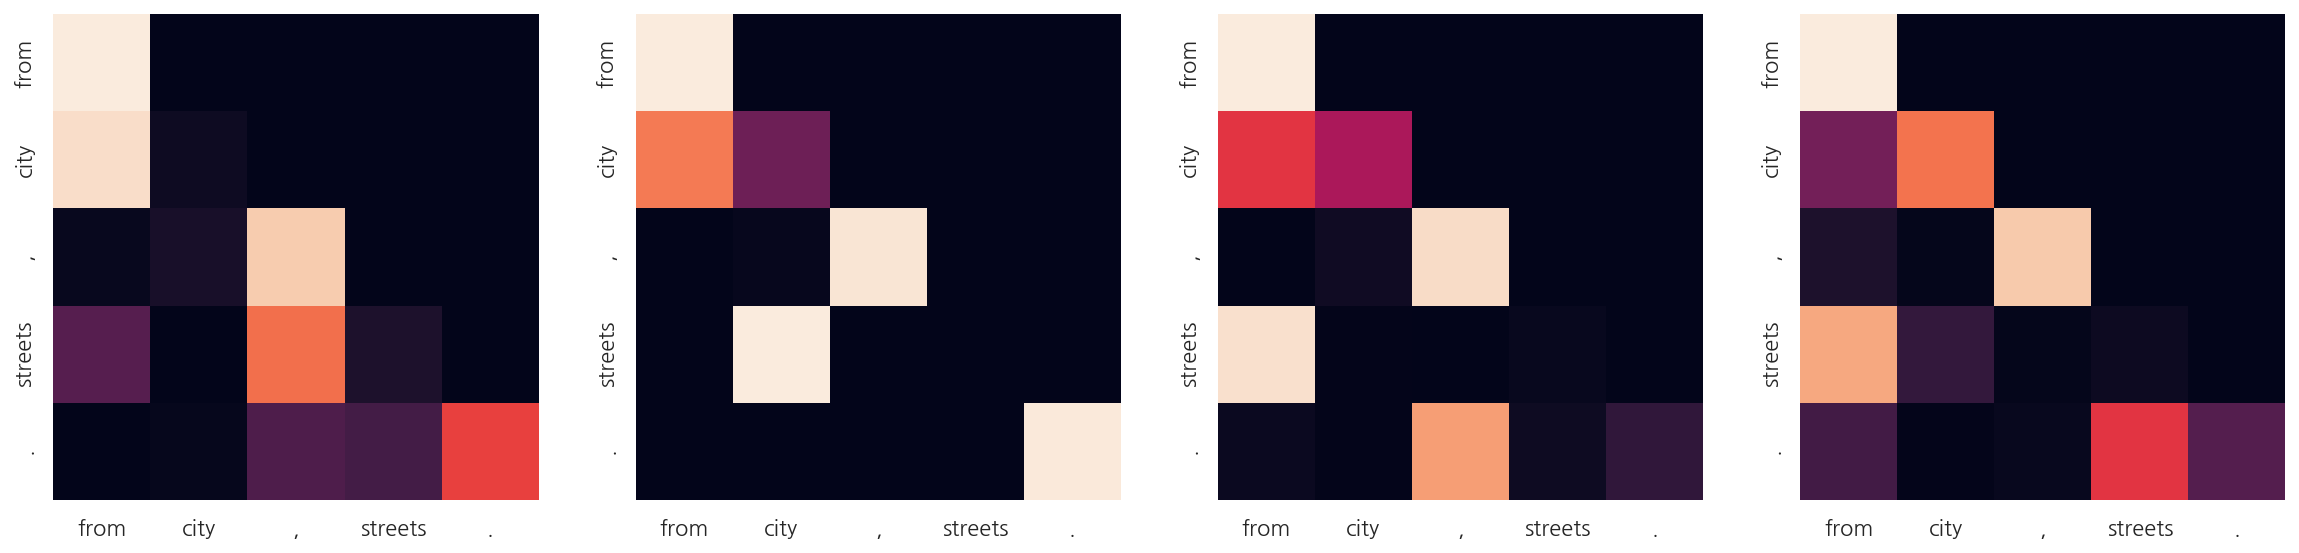

Decoder Src Layer 1


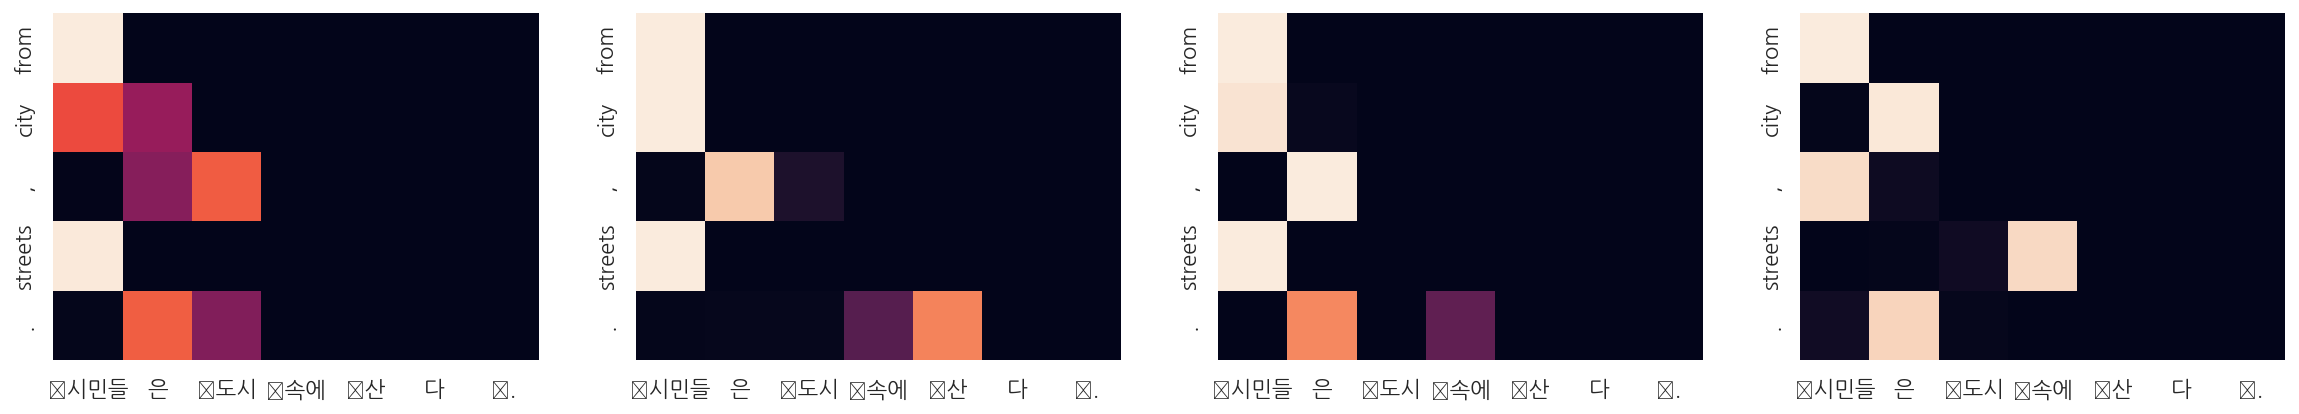

Decoder Self Layer 2


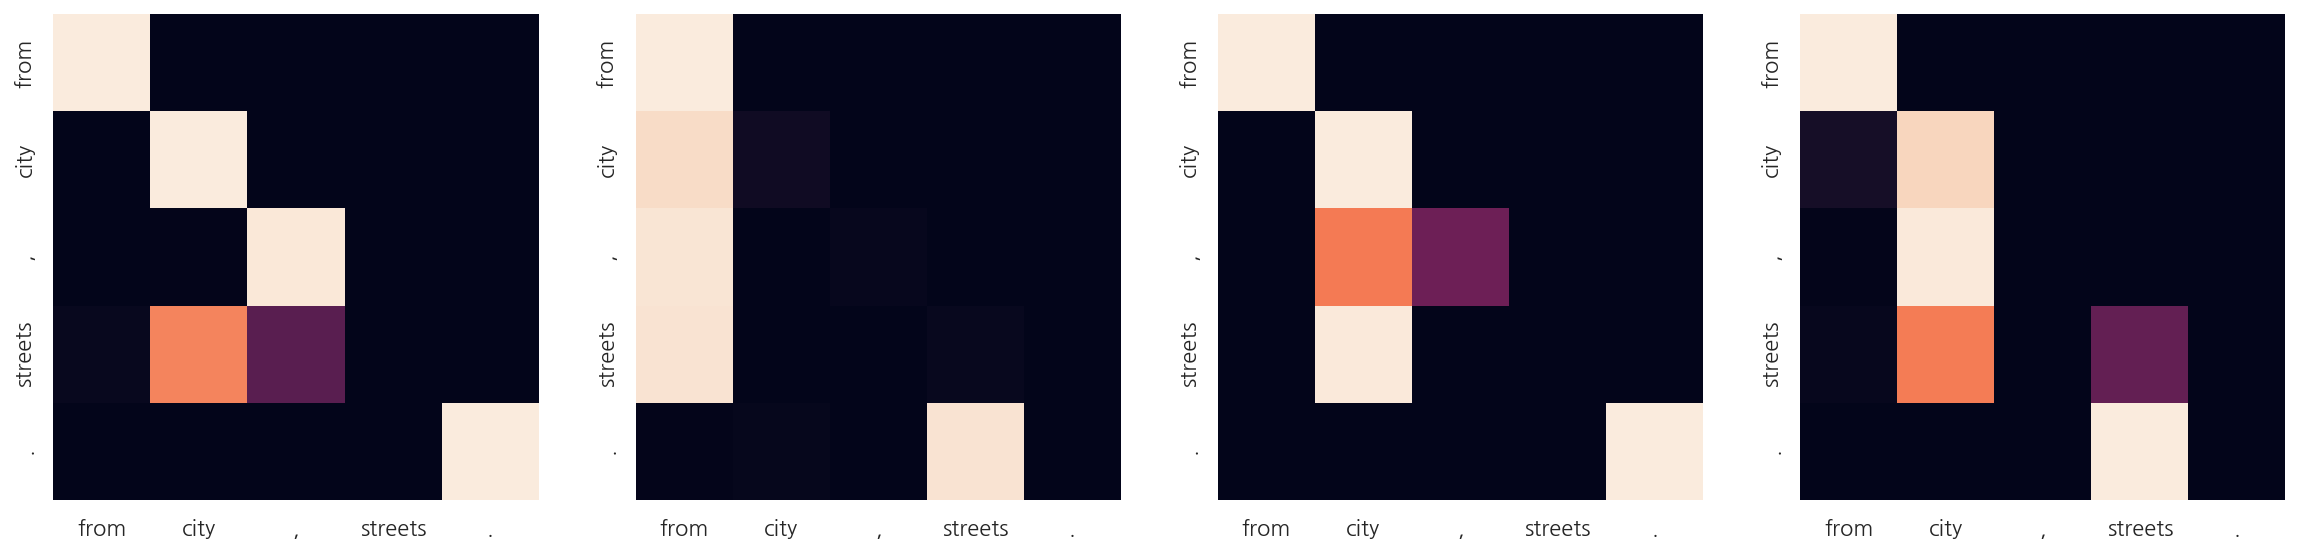

Decoder Src Layer 2


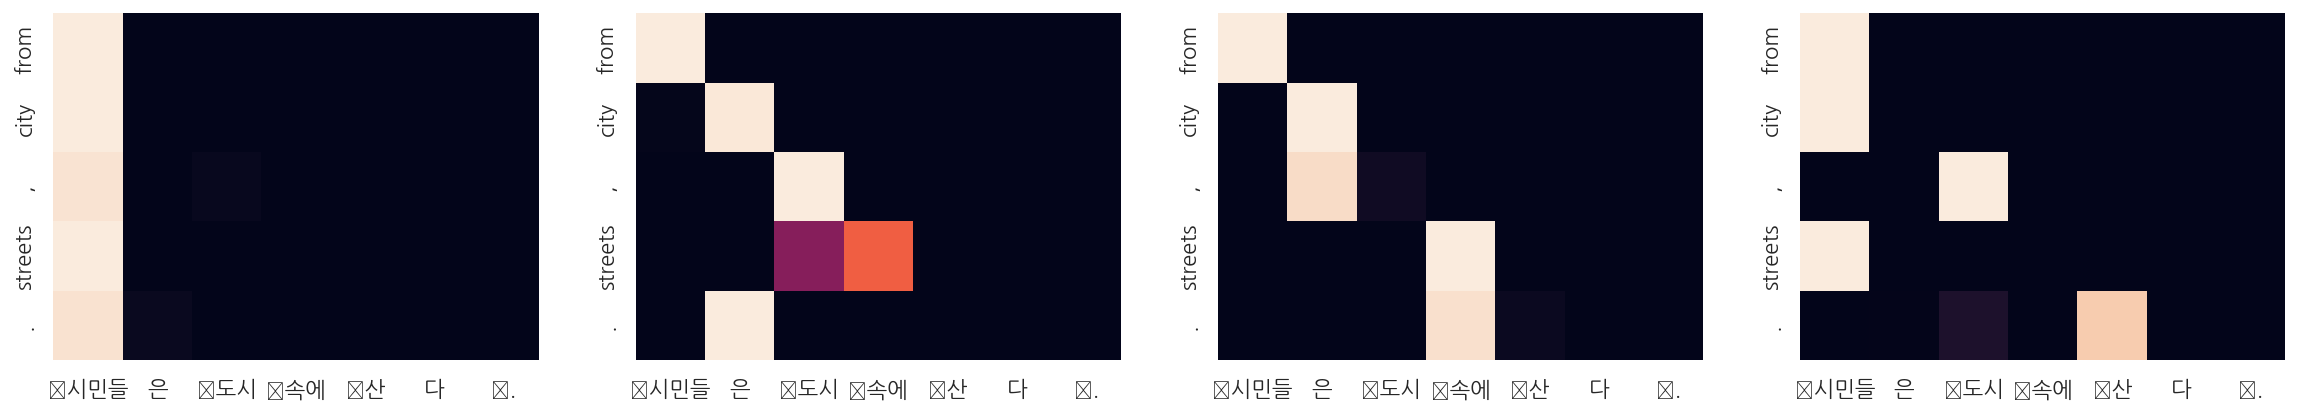

Input: 커피는 필요 없다.
Predicted translation: coffee
Encoder Layer 1


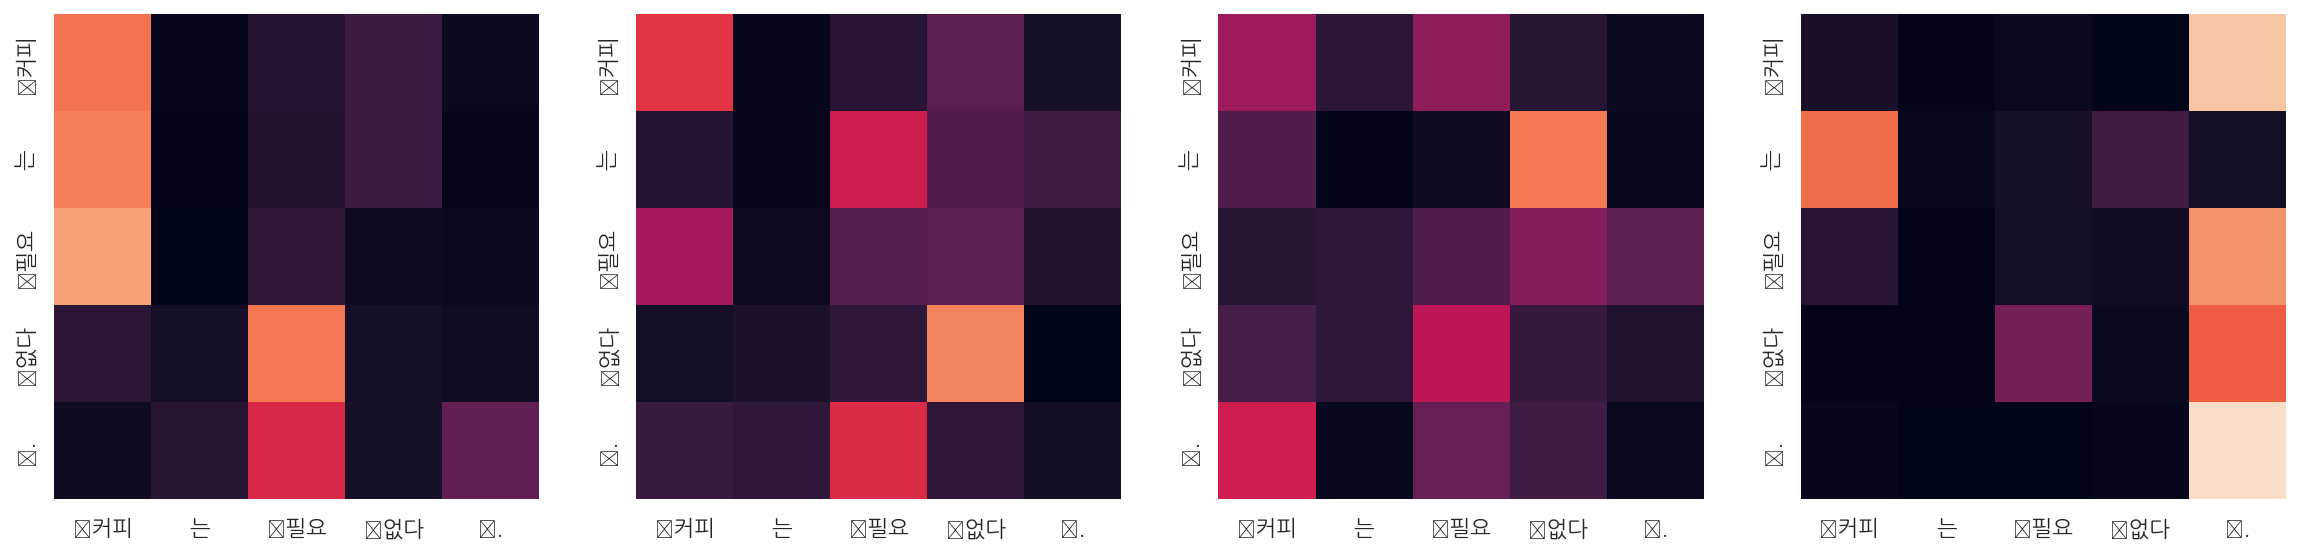

Encoder Layer 2


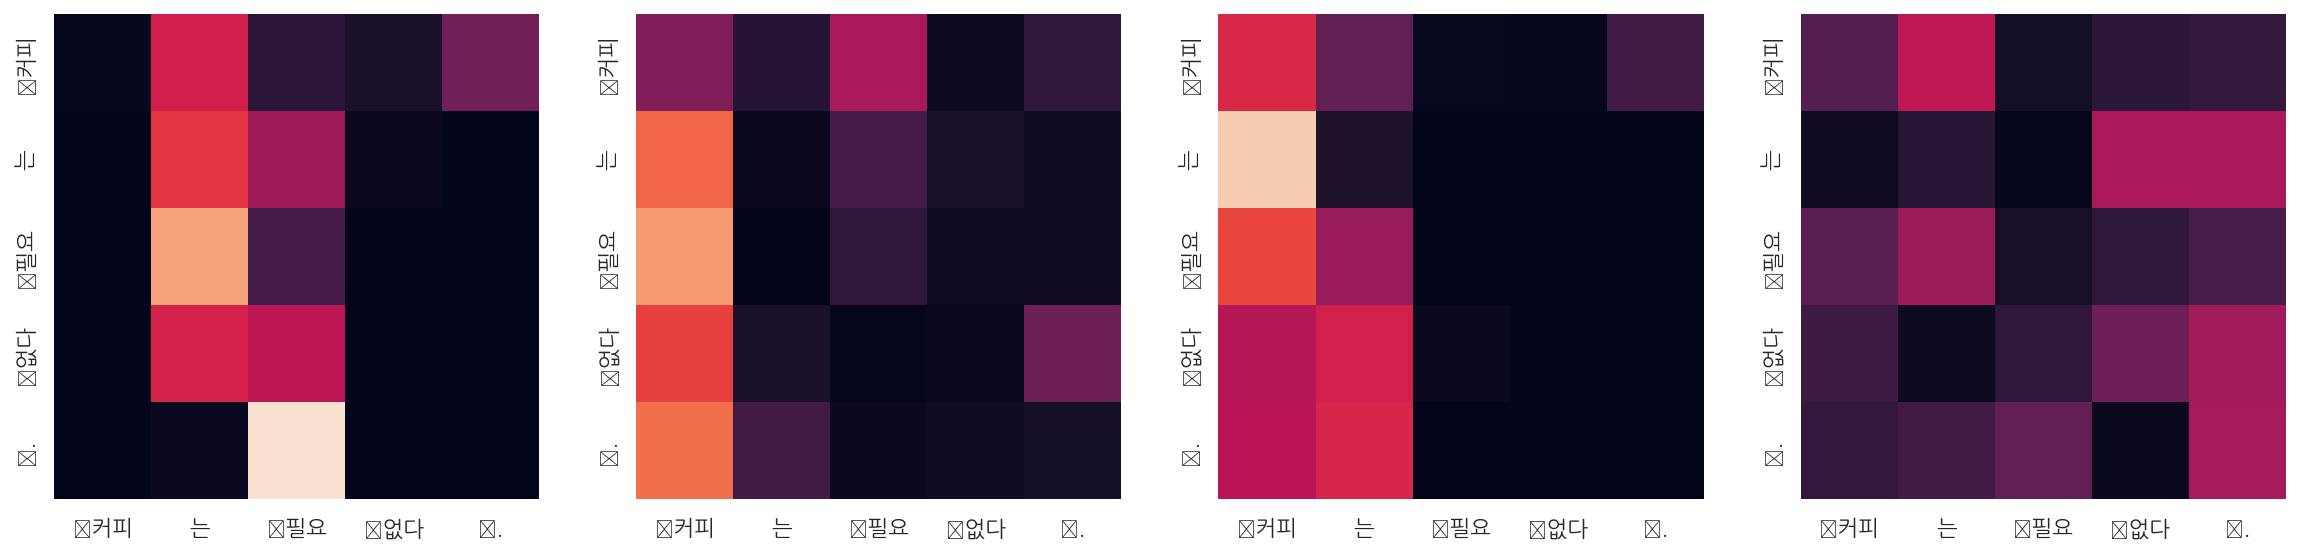

Decoder Self Layer 1


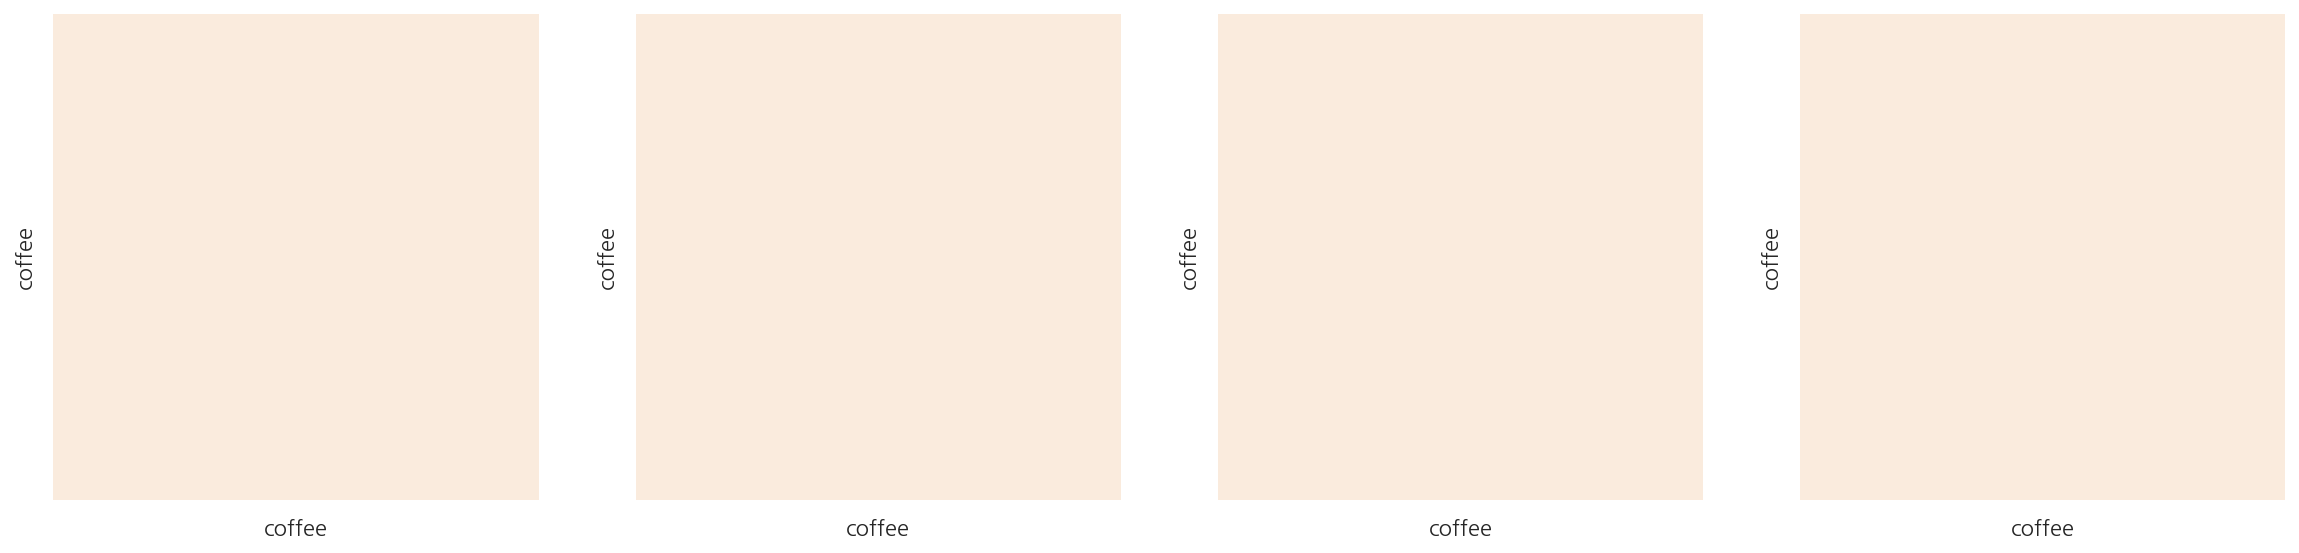

Decoder Src Layer 1


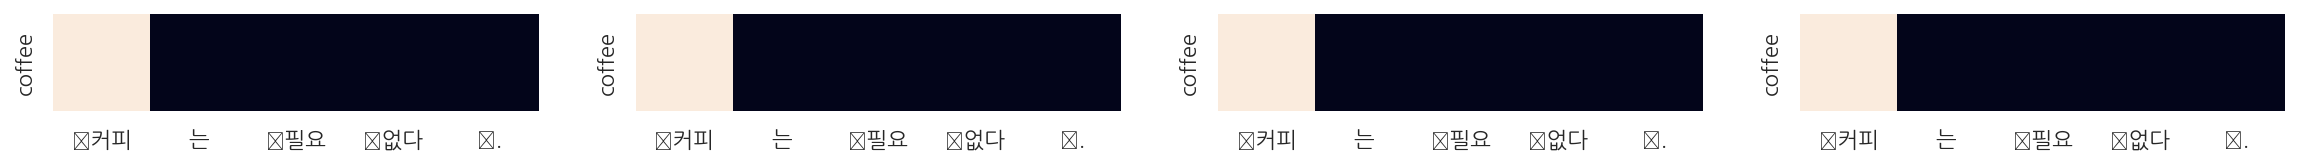

Decoder Self Layer 2


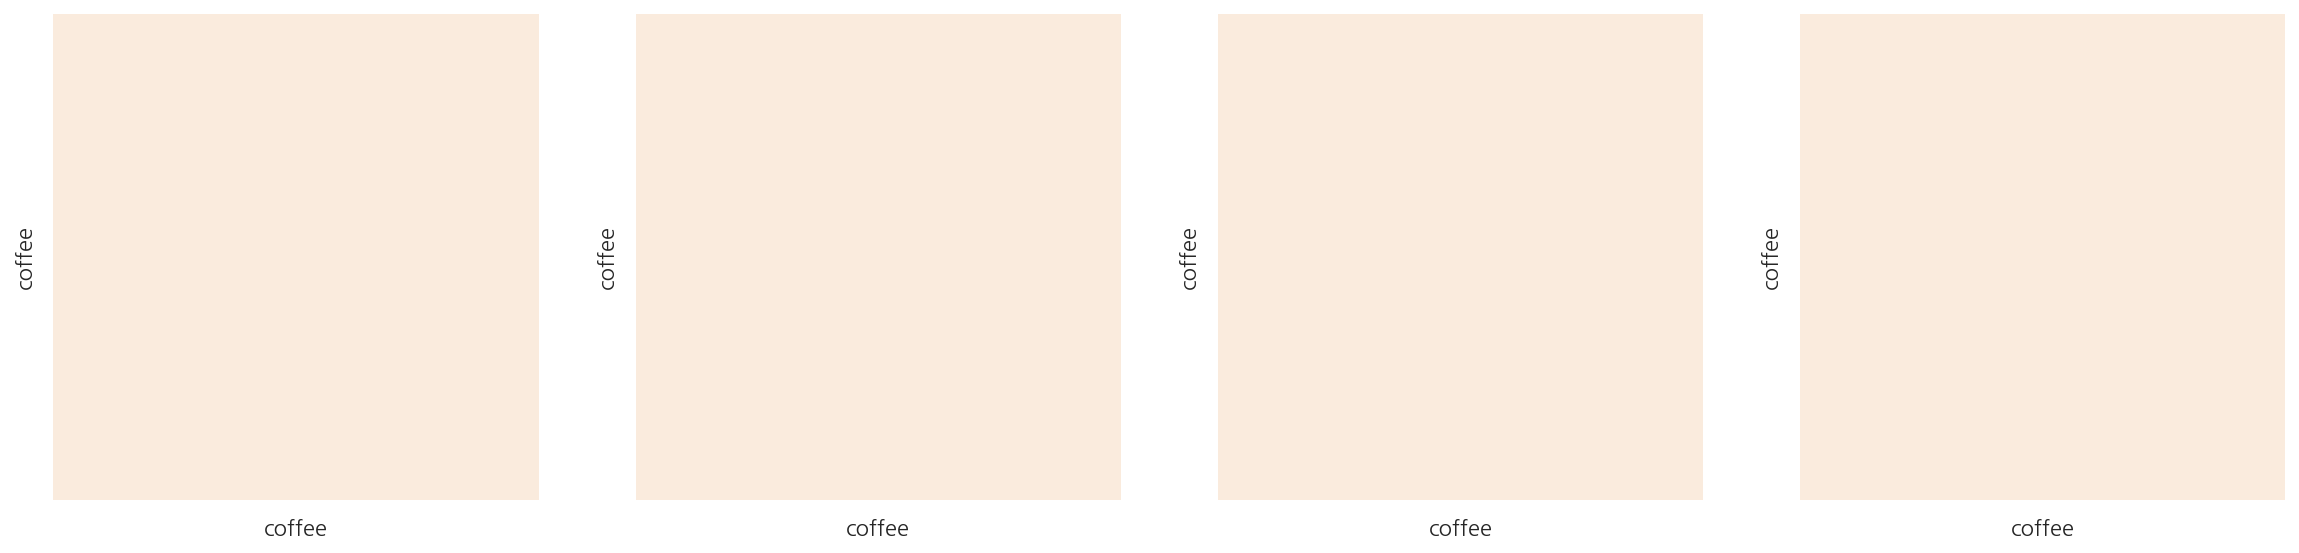

Decoder Src Layer 2


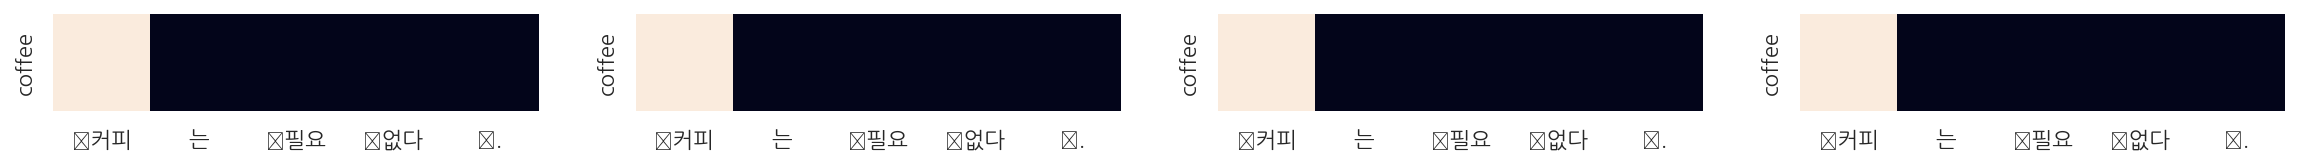

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a . estimated .
Encoder Layer 1


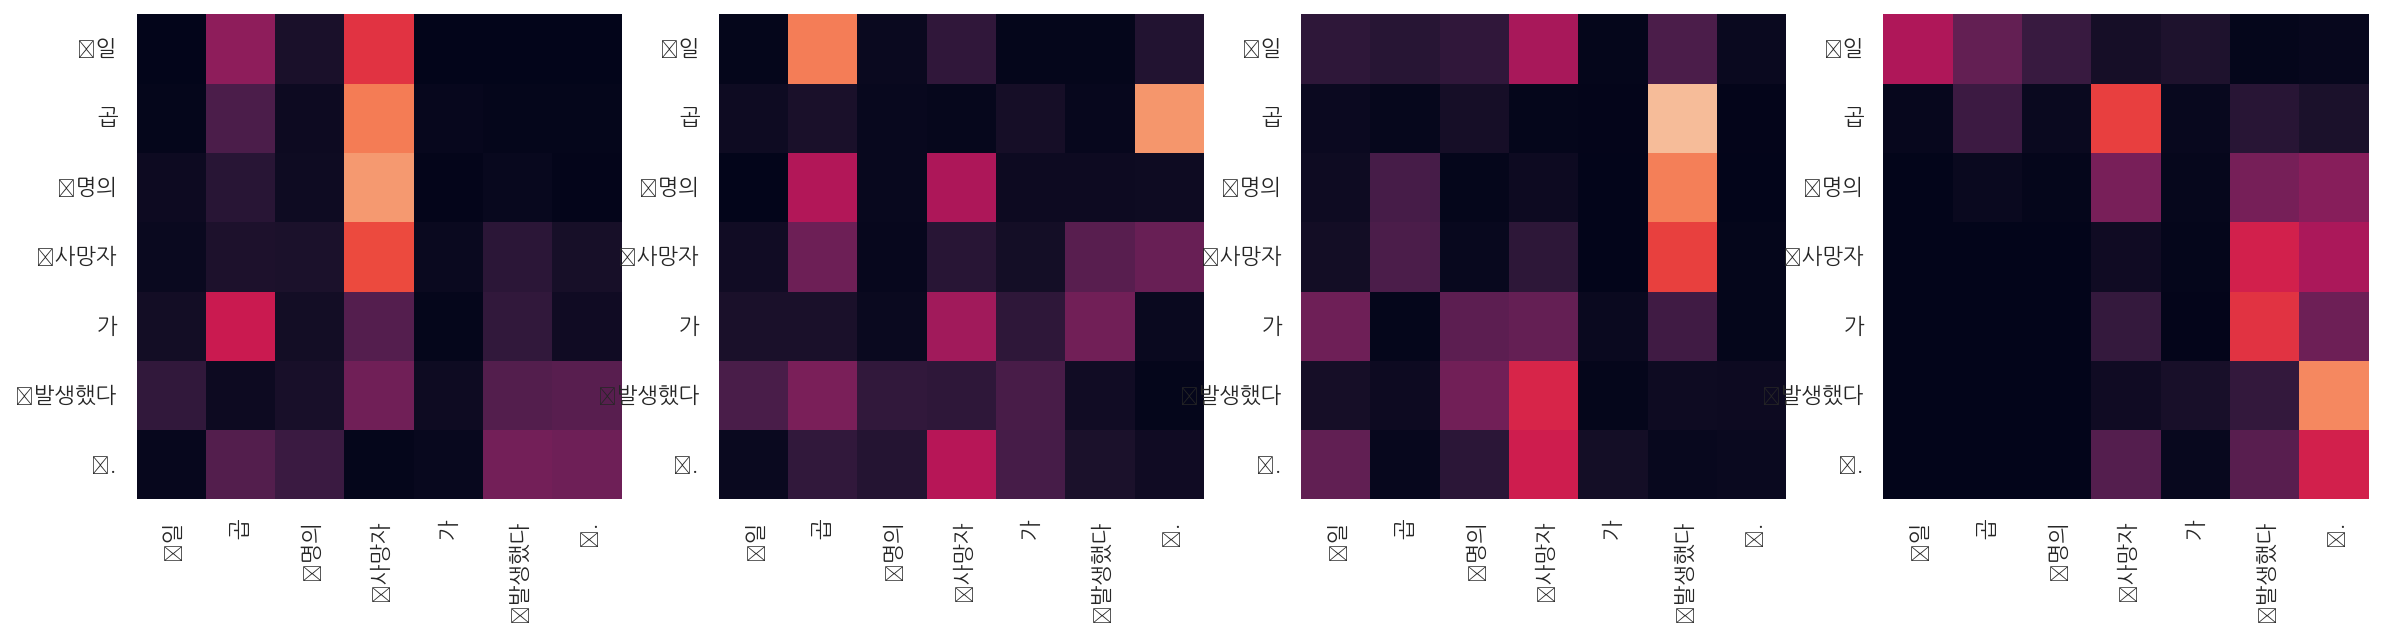

Encoder Layer 2


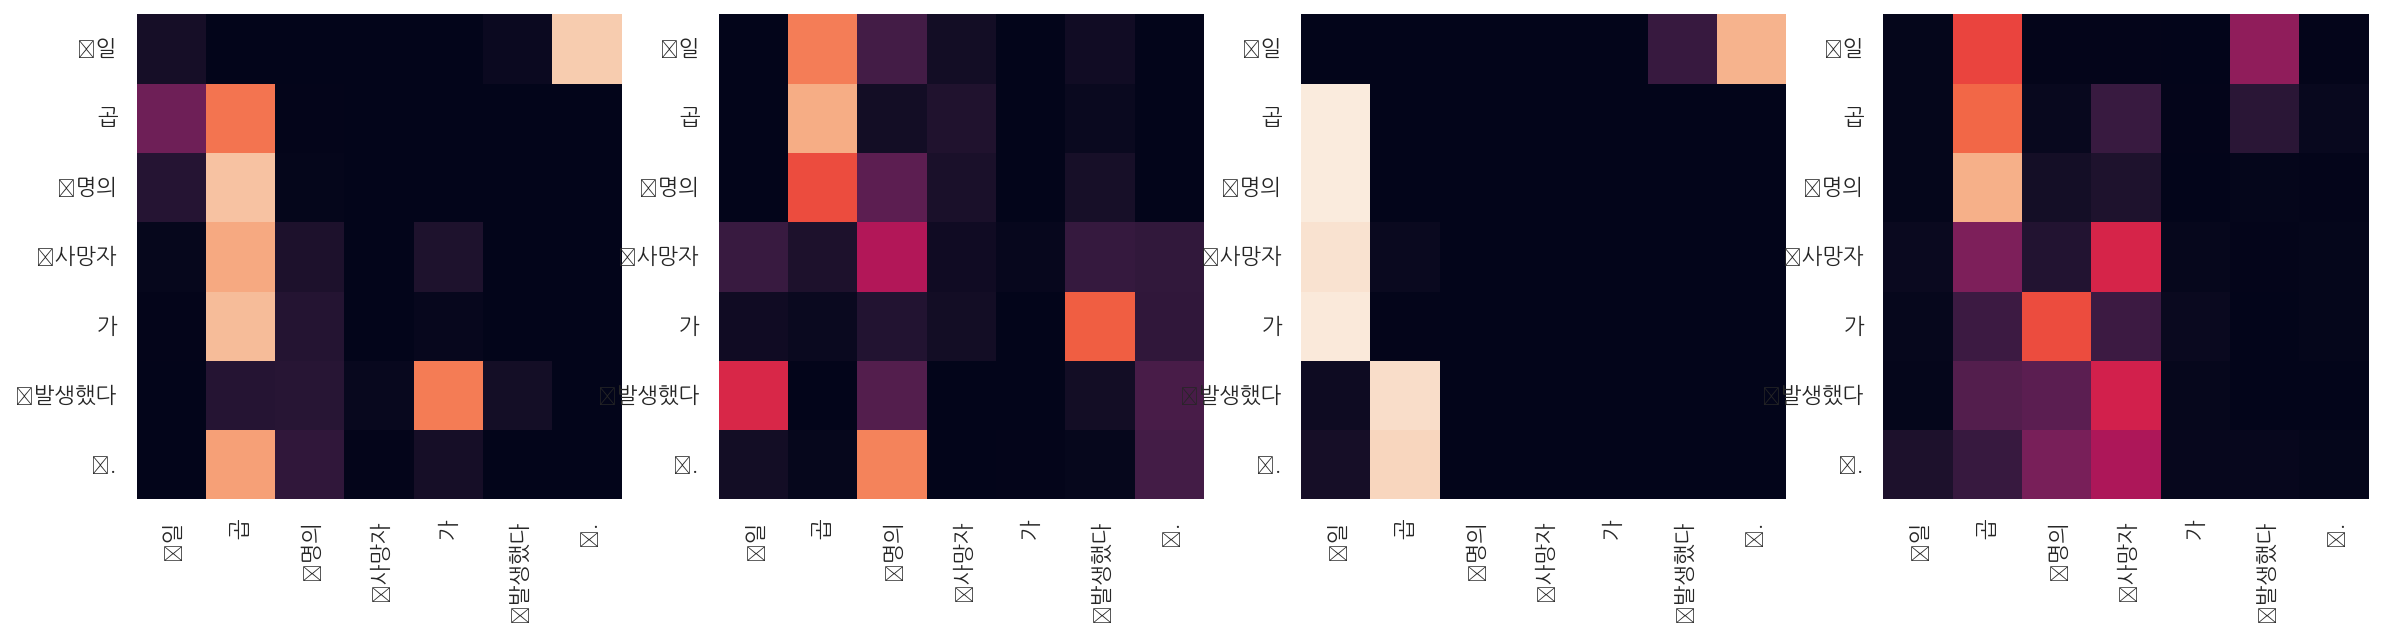

Decoder Self Layer 1


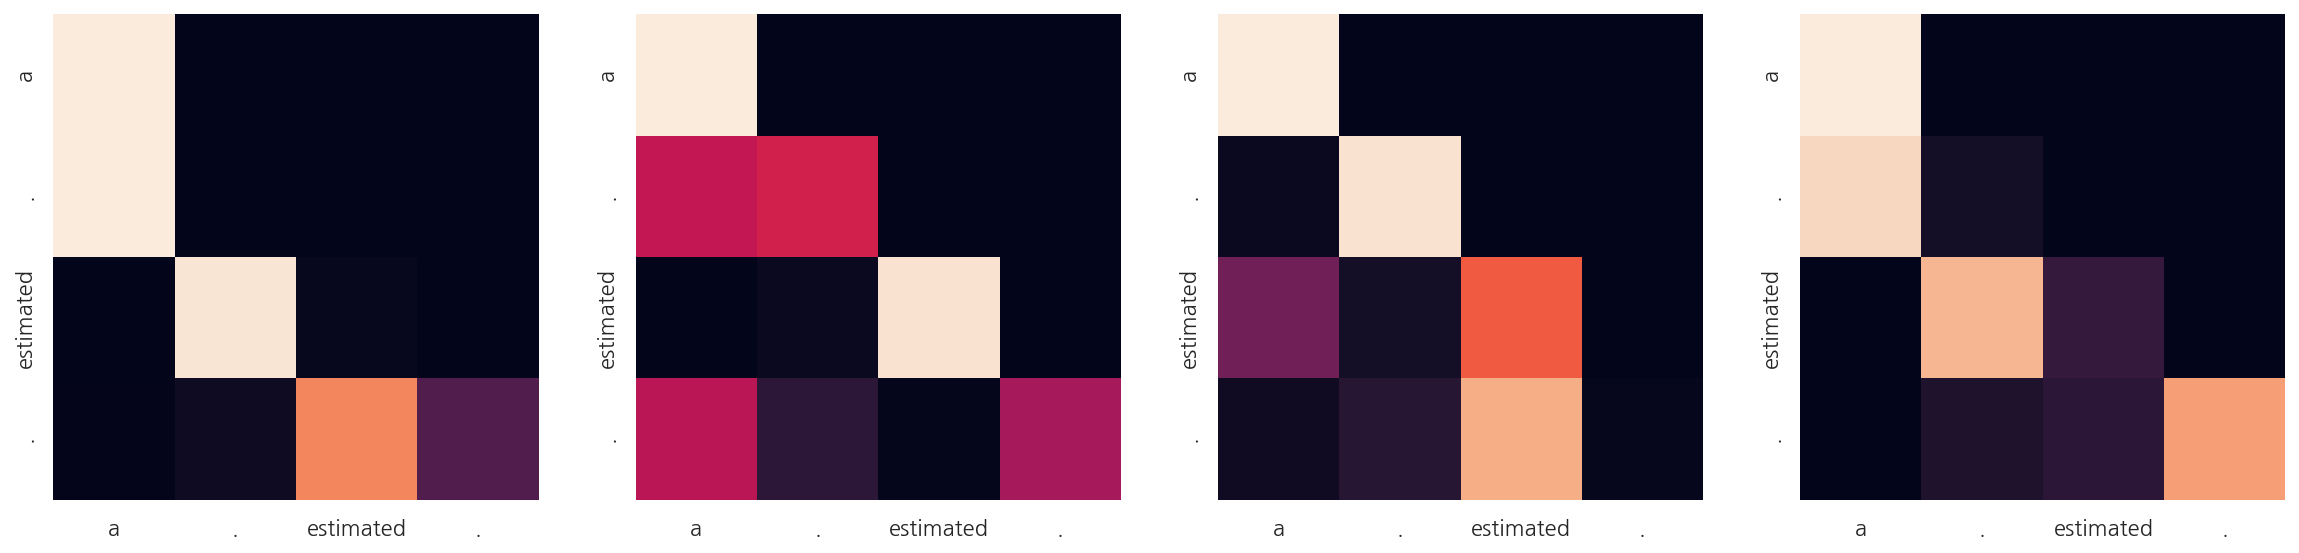

Decoder Src Layer 1


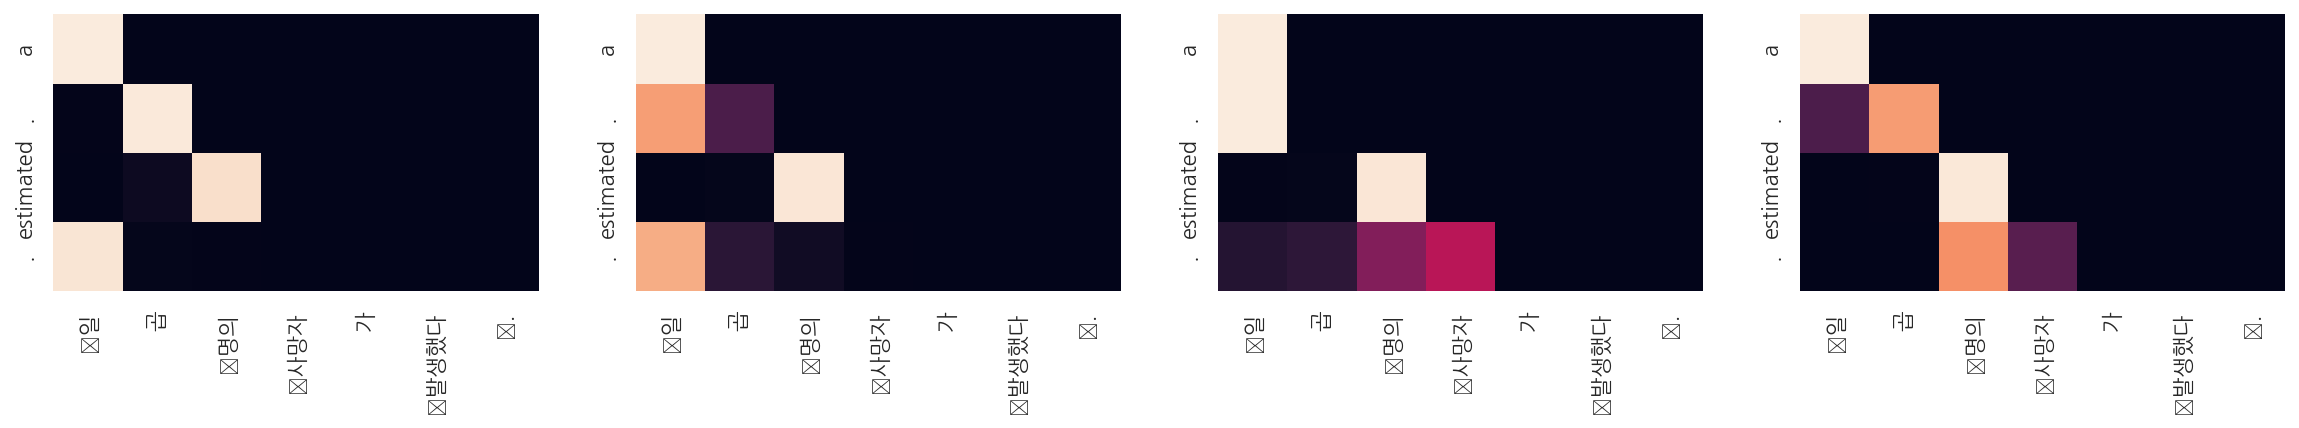

Decoder Self Layer 2


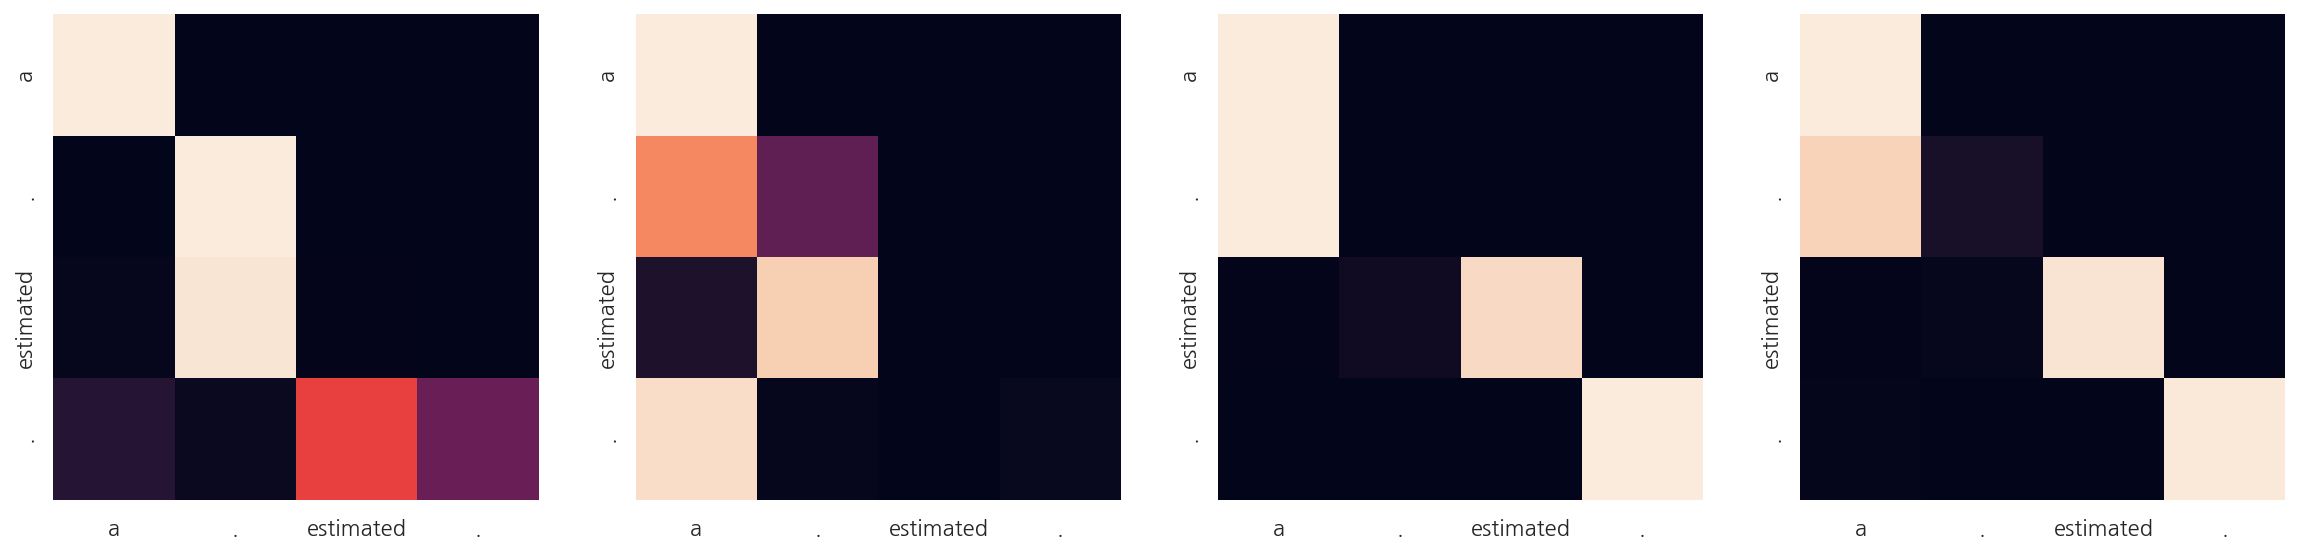

Decoder Src Layer 2


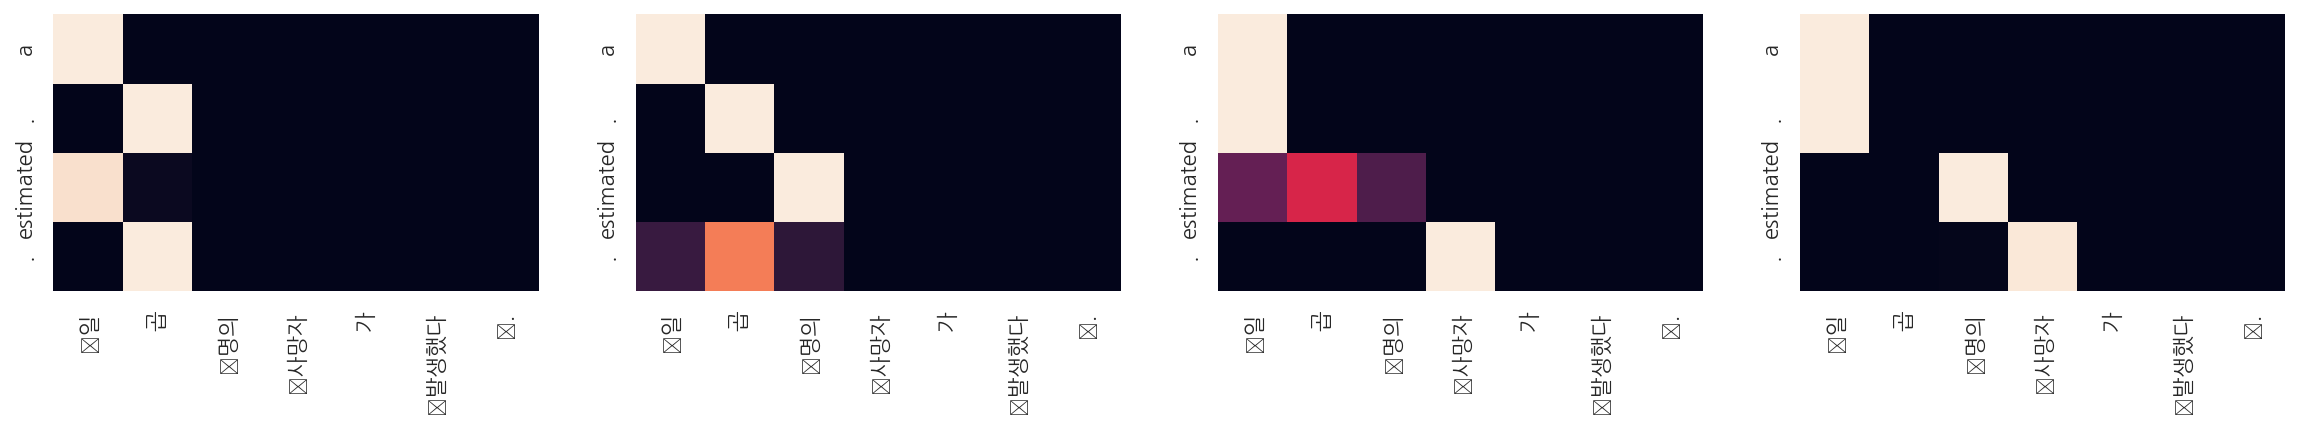

In [28]:
%config InlineBackend.figure_format = 'retina'
seaborn.set(font='NanumGothic')

for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

## 회고

**배운점**

 * Transformer를 이용한 번역기를 간단하게 만들어보았다.
  
**아쉬운점**

 * causality mask, padding mask를 포함한 몇 가지 이슈에 대해 해결하지 못해 좀 더 생각해보아야 겠다.
 
**느낀점**

 * train_step, evaluate, 에포크별 예시 확인, 시각화까지 이번 프로젝트를 통해 좋은 실험 템플릿을 얻은 것 같다.
 
**어려웠던 점**

 * 코드가 길어지면서 각 구조에 대해 계속 헷갈렸다. 예시 코드가 잘 돼어있어서 구현은 했지만, 혼자하기엔 어려울 것 같다.